![](https://hsto.org/files/530/f91/bf0/530f91bf048d46b7ad9f53854d9af266.png)


# Про классификацию, Титаник и Леонардо Ди Каприо

Итак суть задачи состоит в том, чтобы с помощью методов машинного обучения построить модель, которая прогнозировала бы спасется человек или нет. Такая задача, в которой надо научиться разбивать объекты по обучающей выборке на несколько типов называется классификацией. 

Мы с вами только что на доске разобрали несколько алгоритмов и метрик. Делали мы всё это на игрушечных примерах. Пришло время закодить это на компухтере. Подгрузим уже знакомые нам пакеты. 

In [288]:
import pandas as pd                  # Пакет для табличек 
import matplotlib.pyplot as plt      # Пакет для картинок 
plt.style.use('ggplot')              # Красивый стиль картиночек
# Опция, чтобы картинки сразу печатались 
%matplotlib inline                   

__Цель:__ Научиться предсказывать умрёт ли пассажир титаника по его характеристикам. 

Подгрузим данные. 

In [289]:
df = pd.read_csv("02_titanic_train.csv",sep=',',index_col='PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Для начала давайте опишем переменные, которые у нас есть. 

* Survived - выжил человек или нет, целевая переменная 
* Pclass - класс, в котором ехал человек 
* Name - имя человека 
* Sex - пол 
* Age - возраст 
* SibSp - сколько было на борту братьев, сестер, супругов на борту Титаника
* Parch - число детей и родителей на борту Титаника 
* Ticket - номер билета 
* Fare - стоимость билета 
* Cabin - номер каюты 
* Embarked - порт посадки (C = Шербур, Q = Квинстаун, S = Саутгемптон) 

Вот они наши переменные. Часть из них непрерывные, часть категориальные, часть текстовые. Все эти типы переменных требуют предобработки. Заведём для каждого типа переменных свой список.

In [290]:
target_var = 'Survived'  # переменная, которую мы будем прогнозировать

categor_var = ['Pclass','Sex', 'Embarked']     # категориальные
text_var  = ['Name', 'Ticket','Cabin']         # текстовые  
contin_var = ['Age', 'SibSp', 'Parch', 'Fare'] # непрерывные 

Посмотрим на основную информацию о переменных. В ней мы можем уведить какого они типа и сколько в каждой из них пропусков. Обратите внимание, pandas думает, что Pclass числовая. Давайте исправим это. 

In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [292]:
# Скажем пандасу, что мы считаем Pclass категориальной, а не числовой! 
df['Pclass'] = df['Pclass'].astype(str)

In [293]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null object
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(3), object(6)
memory usage: 83.5+ KB


Вообще говоря, переменные, связанные с количеством сестёр и детей также можно было сделать категориальными. Но мы не будем.  Можете попробовать это дома и посмотреть как изменится качество моделей. 

## 1. Предобработка переменных

Все три вида переменных надо предобработать. Каждый вид по-своему. 

### 1.1 Категориальные переменные

Алгоритмы умеют учиться на числах. Надо заменить все категории на числа. Вопрос в том как бы это лучше сделать. Давайте посмотрим на переменную `Embarked` - порт посадки (C = Шербур, Q = Квинстаун, S = Саутгемптон). Она принимает три значения. Возникает соблазн заменить  все S на 1, Q на 2, а C на 3 и дело с концом. 

Это неправильный подход. Если так сделать, то алгоритмы будут дамать, что третий порт самый лучший, а первый самый плохой. Очень большой вопрос почему мы определили порядок портов именно так. Это запутает алгоритм. 

Чтобы не путать алгоритм, поступают следующим образом: делают из категориальной переменной много дамми. Вот так:

In [294]:
df[categor_var].head()  # изначальная табличка

,Pclass,Sex,Embarked
PassengerId,,,
1,3,male,S
2,1,female,C
3,3,female,S
4,1,female,S
5,3,male,S


In [295]:
# Переработали порты в дамми
pd.get_dummies(df.Embarked, dummy_na=True, prefix='embarked').head()

,embarked_C,embarked_Q,embarked_S,embarked_nan
PassengerId,,,,
1,0,0,1,0
2,1,0,0,0
3,0,0,1,0
4,0,0,1,0
5,0,0,1,0


Если человек плыл из порта $C$, то у него в соответствующем столбце будет стоять единичка, а в остальных нули. По аналогии получится с другими портами. 

__Приятный бонус:__  Не нужно бороться с пропусками в переменных. Для пропусков будет своя дамми и мы не потеряем информации. Такой способ работы с категориями называется One Hot Encoding. Дословно можно перевести как одно горячее кодирование.

В чём минус одного горячего кодирования? Можно обжечься. Если категорий внутри переменной много, то мы переработаем её в слишком большое число столбцов. В конечном итоге это может привести к тому, что модели не хватит наблюдений, чтобы научиться в этом огромном числе столбцов ориентироваться.

Есть и другие способы обработки категориальных переменных, но мы будем пользоваться этим. Он самый простой. 

Обратите внимание, что в итоговой таблице у нас есть целых четыре переменные. Одну из них надо выбросить, иначе между столбиками возникает линейная зависимость. То есть один из столбиков дублирует инфомрацию, которая уже есть в других. А нам избыточность ни к чему.

In [296]:
pd.get_dummies(df.Pclass, dummy_na=True, prefix='embarked', drop_first=True).head()

,embarked_2,embarked_3,embarked_nan
PassengerId,,,
1,0,1,0
2,0,0,0
3,0,1,0
4,0,0,0
5,0,1,0


Итоговое одно горяее кодирование будет выглядеть вот так: 

In [297]:
df_categor = pd.get_dummies(df[categor_var], dummy_na=True, drop_first=True)
df_categor.head()

,Pclass_2,Pclass_3,Pclass_nan,Sex_male,Sex_nan,Embarked_Q,Embarked_S,Embarked_nan
PassengerId,,,,,,,,
1,0,1,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0
5,0,1,0,1,0,0,1,0


## 1.2 Непрерывные переменные

С непрерывными переменными надо сделать пару преобразований.  

In [298]:
df_contin = df[contin_var]
df_contin.head() # непрерывные переменные 

,Age,SibSp,Parch,Fare
PassengerId,,,,
1,22.0,1,0,7.2500
2,38.0,1,0,71.2833
3,26.0,0,0,7.9250
4,35.0,1,0,53.1000
5,35.0,0,0,8.0500


Первое заключается в борьбе с пропусками. Алгоритмы оцениваются на числах и не любят пропуски (некоторые настроены к пропускам нейтрально, так как умеют их обрабатывать). У нас в датасете, в переменной `Age` 177 пропусков. Надо как-то с ними поступить.

In [299]:
df_contin.isnull().sum()

Age      177
SibSp      0
Parch      0
Fare       0
dtype: int64

Первое решение: выбросить все эти наблюдения. Проблема такого подхода в том, что другие то переменные для этих наблюдений не пропущены. Значит, выбросив строчки, соответствующие пропускам, мы потеряем кучу информации. Полезной информации. Информацию и без всех наших преобразований легко потерять, сложно найти и невозможно забыть, а мы её ещё и выкинуть хотим. 

Обычно, если пропусков в переменной не очень много, их заполняют чем-нибудь нейтральным. Например, медианами. Когда алгоритм будет натыкаться на них, он будет думать: "Хммм, ну тут ничего особенного, всё как в среднем по выборке, пойду посмотрю другую переменную". И тогда всё будет хорошо. 

Тем не менее, если пропусков в переменной очень много, то лучше выбросить её. Заполнение будет только путать алгоритм. 

Заполним пропуски в возрасте медианами.

In [300]:
df_contin['Age'] = df_contin['Age'].fillna(df_contin['Age'].median())

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Второе преобразование - это стандартизация переменных. Дело в том, что если переменные измерены в разных шкалах (что-то в тоннах, что-то в годах и тд), алгоритм может при обучении заблудиться. Хорошо бы направить его и подтолкнуть в нужном направлении. Таким толчком является стандартизация переменных. 

Из каждой переменной вычетают среднее и делят на стандартное отклонение. Это очищает переменные от своих уникальных шкал и упрощает путь алгоритма к оптимальной точке. 

Мы не будем делать это в этой тетрадке, чтобы не усложнаять изложение. Но в следующий раз точно сделаем. Негоже алгоритмам плутать. 

## 1.3 Текстовые переменные

Работа с текстами это отдельная песня. Они обычно слишком уникальные и мы не можем обработать их по аналогии с категориями. Приходится измываться. Во-первых, варить (создавать) на основе текстов какие-то простые фичи (переменные), во-вторых делать некоторые более сложное вещи. Мы сварим пару простых фичей и успокоимся. 

Первой такой переменной будет длина имён.

In [301]:
df_text = df[text_var]
df_text.head()

,Name,Ticket,Cabin
PassengerId,,,
1,"Braund, Mr. Owen Harris",A/5 21171,NaN
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,C85
3,"Heikkinen, Miss. Laina",STON/O2. 3101282,NaN
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,C123
5,"Allen, Mr. William Henry",373450,NaN


In [302]:
df_text['Name_len'] = df_text['Name'].apply(len)
df_text.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Name,Ticket,Cabin,Name_len
PassengerId,,,,
1,"Braund, Mr. Owen Harris",A/5 21171,NaN,23
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,C85,51
3,"Heikkinen, Miss. Laina",STON/O2. 3101282,NaN,22
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,C123,44
5,"Allen, Mr. William Henry",373450,NaN,24


Второй переменной будет дамми: известен ли номер каюты человека. Если у человека нет каюты, скорее всего он был рабочим. Возможно, эта переменная окажется полезной для алгоритмов. Вообще говоря по номерам кают можно попытаться понять в какой именно части корабля находился человек. Это ещё сильнее улучшит наши алгортмы. Но мы не будем делать это. 

In [303]:
df_text['Cabin_isnull'] = df_text.Cabin.isnull().astype(int)
df_text.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Name,Ticket,Cabin,Name_len,Cabin_isnull
PassengerId,,,,,
1,"Braund, Mr. Owen Harris",A/5 21171,NaN,23,1
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,C85,51,0
3,"Heikkinen, Miss. Laina",STON/O2. 3101282,NaN,22,1
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,C123,44,0
5,"Allen, Mr. William Henry",373450,NaN,24,1


Выбросим из таблицы все изначальные тексты.

In [304]:
df_text.drop(['Name','Ticket','Cabin'], axis=1, inplace=True)
df_text.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Name_len,Cabin_isnull
PassengerId,,
1,23,1
2,51,0
3,22,1
4,44,0
5,24,1


## 1.4 Объединяем полученое добро 

Предобработка закончилась. Сливаем все наши таблички в одну общую.

In [305]:
df = pd.concat([df[target_var],df_contin, df_categor, df_text], axis=1)
df.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Pclass_nan,Sex_male,Sex_nan,Embarked_Q,Embarked_S,Embarked_nan,Name_len,Cabin_isnull
PassengerId,,,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,0,1,0,1,0,0,1,0,23,1
2,1,38.0,1,0,71.2833,0,0,0,0,0,0,0,0,51,0
3,1,26.0,0,0,7.9250,0,1,0,0,0,0,1,0,22,1
4,1,35.0,1,0,53.1000,0,0,0,0,0,0,1,0,44,0
5,0,35.0,0,0,8.0500,0,1,0,1,0,0,1,0,24,1


Проверим, остались ли пропуски.

In [306]:
df.isnull().sum()

Survived        0
Age             0
SibSp           0
Parch           0
Fare            0
Pclass_2        0
Pclass_3        0
Pclass_nan      0
Sex_male        0
Sex_nan         0
Embarked_Q      0
Embarked_S      0
Embarked_nan    0
Name_len        0
Cabin_isnull    0
dtype: int64

Перед тем как строить модели посмотрим на распределение целевой переменной. Видм, что классы не сбалансированы. Выжило меньше, чем погибло. Это может привести к проблемам при обучении алгоритмов. Попробуйте понять почему. 

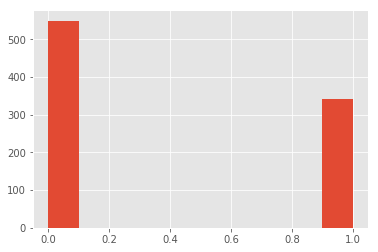

In [307]:
df.Survived.hist()

# 2. Разбиение на тренировочную выборку и тестовую

Вытаскиваем из наших данных целевую переменную: выживаемость! Запишем её в $y$, остальное запишем в $X$. 

In [308]:
y = df['Survived'].values
X = df.drop('Survived',axis=1).values
X.shape, y.shape

((891, 14), (891,))

Для того, чтобы понять, как хорошо мы обучили алгоритм, нужно отложить немного выборки в сторону. Выборка, на которой мы учимся, не подходит для этих целей. Так как знания об этих объектах уже будут лежать в нашей модели, а в реальной жизни будут встречаться и новые, ранее неизвестные объекты. 

Часть, которую мы отложили, алгоритм ещё не видел. Значит можно использовать её для имитации этих самых новых объектов из реальной жизни и посмотреть какое на них будет качество. 

Раздробим всё, что имеем на две части. Одна часть будет чуть больше, другая чуть меньше. Обычно на обучение пускают 70-80%, а на тест 30-20% выборки. 

In [309]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(623, 14) (623,)
(268, 14) (268,)


# 3. Метод ближайшего соседа

Самый простой алгоритм - метод ближайших соседей. Мы разобрали пару примеров на него у доски. Напомню, что он заключается в том, что мы ищем тех, кто сильнее всего похож на наш объект и приписываем ему тот же класс. Попробуем обучить метод одного ближайшего соседа. 

In [310]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(n_neighbors=1)
clf_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

Три строчки и у нас есть алгоритм, наученый жизни. Попробуем посмотреть что он предскажет нам на той части выборки, которую мы отложили. Это поможет нам понять как часто мы делаем ошибки. 

In [311]:
y_predicted = clf_knn.predict(X_test)
y_predicted

array([1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1])

Разные метрики качества мы с вами разобрали на доске. Если вы не поняли их, можно [глянуть лекцию Жени Соколова.](https://www.coursera.org/learn/vvedenie-mashinnoe-obuchenie/lecture/IVuAc/mietriki-kachiestva-klassifikatsii-1)  Расскажите потом понятной она вам показалась или непонятной, если будете смотреть.

Вкратце напомню о чём шла речь. Предсказывая выживаемость на корабле, мы можем совершить ошибки двух видов: 

* Ошибка первого рода: мы предсказали человеку, что он выживет, а он погиб.
* Ошибка второго рода: мы предсказали, что человек погибнет, а он выжил.

В разных задачах критичны разные виды ошибок. На основе этих ошибок можно придумать много метрик. Мы с вами построили вот такую табличку  

![](http://blog.exsilio.com/wp-content/uploads/2016/09/table-blog.png)

и обсудили слудущие метрики качества: 

1)Доля верно классифицированных объектов:

$$Accuracy = \frac{TP + TN}{TP + FP + TN + FN}$$

Интуитивно понятная, очевидная и почти неиспользуемая метрика. Её главная проблема в том, что она бесполезна в задачах с неравными классами. Например, пусть у нас есть $50$ больных и $950$ здоровых. Мы хотим научиться их различать. Пусть наш алгоритм предсказывает, что все здоровы. В этом случае доля правлиьных ответов составит $95\%$, но алгорим окажется абсолютно бесполезным. 

Чтобы избежать таких эксцессов, а также учитывать, что разные типы ошибок могут иметь разную цену, строят другие две метрики: точность и полноту. 

2)Точность (precision): 

$$P = \frac{TP}{TP + FP}$$

Отражает то, насколько мы можем доверять алгоритму, если он спрогнозирвоал единичку. 

3)Полнота (Recall): 

$$R = \frac{TP}{TP + FN}$$

Показывает, как много объектов первого класса наш алгоритм находит.

Введение precision не позволяет нам записывать все объекты в один класс, так как в этом случае мы получаем рост уровня False Positive. Recall демонстрирует способность алгоритма обнаруживать данный класс вообще, а precision — способность отличать этот класс от других классов.

Давайте составим для алгоритма из первого пункта матрицу ошибок и подсчитаем эти две метркии. Под классом $1$ будем понимать больных. Именно их мы хотели бы найти.  

|          | $y=1$ | $y=0$ |
|----------|-------|-------|
|$a(x) = 1$|  0    |  0    | 
|$a(x) = 0$|  50   |  950  | 

Точность будет равна нулю. Полнота тоже. Мы видим насколько алгоритм никчёмен. 

Более высокая точность влечёт более низкую полноту. Баланс между этими характеристиками выбирается в зависимости от задачи. В случае поиска больных, на бы хотелось получить максимальную полноту. Нестрашно, если здоровый сдаст анализы, страшно если мы пропустим больного. В задаче выдаче кредитов, наоборот, важнее точность.

Можно склеить эти две метрики, посчитав их среднее гармонческое и получить f-меру: 

4)F-measure: 

$$F = \frac{1}{\beta\frac{1}{P} + (1 - \beta)\frac{1}{R}}$$

Параметр $\beta$ в данном случае определяет вес точности в метрике. $\beta = 1$ вносит точность и полноту с одинаковыми весами. Изменяя его, можно отдавать предпочтения либо одному либо другому. 

Все эти метрики уже есть в пакете sklearn. По уму надо бы реализовать их самостоятельно, чтобы лучше понять, но у нас на это нет особо времени, поэтому это домашнее задание :) 

In [312]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy =', accuracy_score(y_test, y_predicted))
print('Precision =', precision_score(y_test, y_predicted))
print('Recall =', recall_score(y_test, y_predicted))
print('F1_score =', f1_score(y_test, y_predicted))

Accuracy = 0.6529850746268657
Precision = 0.59375
Recall = 0.5135135135135135
F1_score = 0.5507246376811593


Неплохо для очень простой модели. Но можно лучше. Давайте попробуем взять не один ближайший объект, а сразу семь!

In [313]:
clf_knn = KNeighborsClassifier(n_neighbors=7)
clf_knn.fit(X_train, y_train)
y_predicted = clf_knn.predict(X_test)

In [314]:
print('Accuracy =', accuracy_score(y_test, y_predicted))
print('Precision =', precision_score(y_test, y_predicted))
print('Recall =', recall_score(y_test, y_predicted))
print('F1_score =', f1_score(y_test, y_predicted))

Accuracy = 0.6865671641791045
Precision = 0.6588235294117647
Recall = 0.5045045045045045
F1_score = 0.5714285714285714


Уже лучше. 
Более того, теперь мы можем говорить с какой вероятностью объект принадлежит классу. В данном случае вероятности - это доля соседей "проголосовавших" за соответствующий класс.

In [315]:
y_proba = clf_knn.predict_proba(X_test)
y_proba[:10]

array([[0.28571429, 0.71428571],
       [0.42857143, 0.57142857],
       [0.71428571, 0.28571429],
       [0.42857143, 0.57142857],
       [0.57142857, 0.42857143],
       [0.42857143, 0.57142857],
       [0.71428571, 0.28571429],
       [0.85714286, 0.14285714],
       [0.57142857, 0.42857143],
       [0.57142857, 0.42857143]])

Теперь, имея вероятностное представление того, что человек выживет, можно усложнить модель введя отсечение по этому значению. Чем большее значение порога мы поставим, тем выше будет точность модели и тем ниже будет полнота. 

In [316]:
y_predicted = (y_proba[:,1] >= 0.6)
y_predicted[:10]

array([ True, False, False, False, False, False, False, False, False,
       False])

In [317]:
print('Accuracy =', accuracy_score(y_test, y_predicted))
print('Precision =', precision_score(y_test, y_predicted))
print('Recall =', recall_score(y_test, y_predicted))
print('F1_score =', f1_score(y_test, y_predicted))

Accuracy = 0.6828358208955224
Precision = 0.7321428571428571
Recall = 0.36936936936936937
F1_score = 0.4910179640718564


Получается неприятная ситуация. Все метрики, которые мы выше обсудили, зависят от того, какой порог выставить. Это не очень круто. Хотелось бы получить что-то универсально, не зависящее от порога. 

Одним из способов оценить модель в целом, не привязываясь к конкретному порогу, является $ROC-AUC$ — площадь (Area Under Curve) под кривой ошибок. Данная кривая представляет из себя линию от $(0,0)$ до $(1,1)$ в координатах $True Positive Rate (TPR)$ и $False Positive Rate (FPR)$:

True Positive Rate: $$TPR = \frac{TP}{TP + FN}$$

False Positive Rate: $$FPR = \frac{FP}{FP + TN}$$

$TPR$ нам уже известна, это полнота, а $FPR$ показывает, какую долю из объектов negative класса алгоритм предсказал неверно. В идеальном случае, когда классификатор не делает ошибок $(FPR = 0, TPR = 1)$ мы получим площадь под кривой, равную единице; в противном случае, когда классификатор случайно выдает вероятности классов, $ROC-AUC$ будет стремиться к $0.5$, так как классификатор будет выдавать одинаковое количество $TP$ и $FP$.

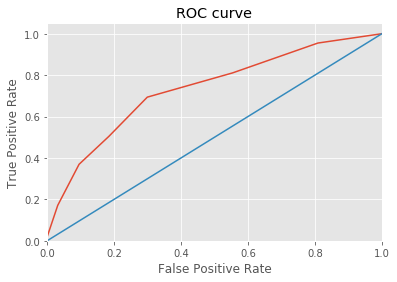

In [321]:
# подгружаем из пакета метрику roc_auc 
# и функцию для строительства кривой
from sklearn.metrics import roc_auc_score, roc_curve

# перебираем пороги и ищем для каждого fpr и tpr: 
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1])

# Рисуем картиночку
plt.plot(fpr, tpr, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [322]:
# считаем площадь под кривой
print('AUC =', roc_auc_score(y_test, y_proba[:,1]))

AUC = 0.7312503586388938


Чем больше площадь под кривой, тем качественнее классификатор. 
Значение $AUC = 0.5$ говорит о непригодности модели, это равносильно случайному гаданию.

Давайте попробуем перебором соседей узнать какое количество будет давать самое крутое значение $ROC-AUC$. 

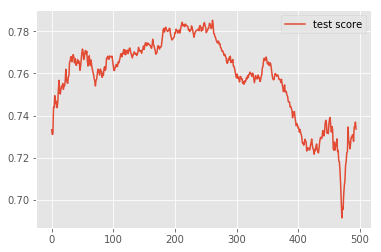

In [327]:
rocauc_train = [ ]
rocauc_test = [ ]

for k in range(5,500):
    clf_knn = KNeighborsClassifier(n_neighbors=k)
    clf_knn.fit(X_train, y_train)
    
    # Ошибка на тестовой выборке 
    y_proba = clf_knn.predict_proba(X_test)
    rocauc_test.append(roc_auc_score(y_test, y_proba[:,1]))
    
plt.plot(rocauc_test, label='test score')
plt.legend()

Что же мы видим? С некоторого значения количества соседей качество модели на тестовой выборке начинает падать. Данный эффект называется _переобучением_: модель избыточной сложности хорошо запоминает тренировочную выборку, но на новых, неизвестных данных предсказательная способность падает.

Посмотрим на максимальный показатель метрики и оптимальное число соседей.

In [328]:
max(rocauc_test)

0.7852183393584669

In [329]:
rocauc_test.index(max(rocauc_test)) + 1  # Почему +1? 

262

# 4. Деревья да леса

Можно ли выявить выживших, не обращаясь к прямому сравнению другими? Можно! Для этого нужно использовать другие алгоритмы. Например, деревья решений. 

Деревья решений используются в повседневной жизни в самых разных областях человеческой деятельности, порой и очень далеких от машинного обучения. Деревом решений можно назвать наглядную инструкцию, что делать в какой ситуации. Например, можно составить вот такую инсрукцию, связанную с выдачей человеку кредита: 

![](https://hsto.org/files/194/9b6/ae9/1949b6ae97ab4fc9b1a37fbf182eda8f.gif)

Дерево решений как алгоритм машинного обучения – по сути то же самое: объединение логических правил вида "Значение признака  меньше  И Значение признака  меньше … => Класс 1" в структуру данных "Дерево". Машинное обучение тут заключается в поиске оптимальных порогов для разбиения. Обычно такие пороги ищут жадно. Если порог очень сильно понижает ошибку модели, он нам подходит. Более глубоко мы попытались это осознать, решая на доске игрушечную задачку. 

In [334]:
from sklearn.tree import DecisionTreeClassifier # подгрузили дерево

In [335]:
clf_tree = DecisionTreeClassifier()     # объявили дерево
clf_tree.fit(X_train, y_train)          # научили дерево
y_predicted = clf_tree.predict(X_test)  # предсказали метки класса
y_proba = clf_tree.predict_proba(X_test)# предсказали вероястности

Accuracy = 0.75
Precision = 0.7156862745098039
Recall = 0.6576576576576577
F1_score = 0.6854460093896714
AUC = 0.739054340965169


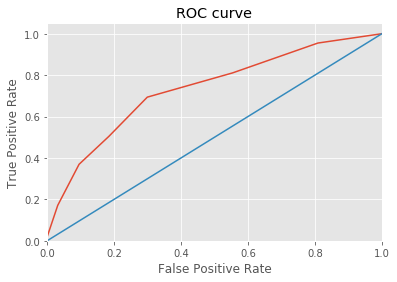

In [336]:
print('Accuracy =', accuracy_score(y_test, y_predicted))
print('Precision =', precision_score(y_test, y_predicted))
print('Recall =', recall_score(y_test, y_predicted))
print('F1_score =', f1_score(y_test, y_predicted))
print('AUC =', roc_auc_score(y_test, y_proba[:,1]))

# Рисуем картиночку
plt.plot(fpr, tpr, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

На решающем дереве мы можем посмотреть насколько сильно какая из переменных уменьшала ошибку при разбиении. Чем сильнее она это сделала, тем она важнее.

In [337]:
featureImportance = pd.DataFrame({"feature": df.drop('Survived',axis=1).columns, 
                                  "importance": clf_tree.feature_importances_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance

,importance
feature,
Sex_male,0.286618
Age,0.160336
Name_len,0.155897
Fare,0.154372
Pclass_3,0.089074
SibSp,0.053140
Cabin_isnull,0.030073
Embarked_S,0.025960
Pclass_2,0.016410


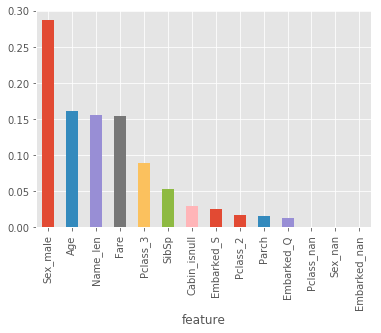

In [338]:
featureImportance["importance"].plot('bar')

Одно дерево обладает важным недостатком: оно очень сильно фрагментирует выборку. Иначе говоря, запоминает её и переобучается. Чтобы избавиться от этой проблемы, обычно выращивают много деревьев: лес. Взращивая лес, деревья стараются сделать максимально независимыми друг от друга. Это позволит каждому из них фрагментировать выборку по-своему и в среднем не переобучиться. Для этого внутрь алгоритма пихают кучу разных интересных штук, которые мы в этом курсе рассматривать не будем. 

In [339]:
from sklearn.ensemble import RandomForestClassifier

In [342]:
rfc = RandomForestClassifier(n_estimators=10) # число деревьев в лесе
rfc.fit(X_train, y_train)
y_predicted = rfc.predict(X_test)
y_proba = rfc.predict_proba(X_test)

Accuracy = 0.7873134328358209
Precision = 0.78125
Recall = 0.6756756756756757
F1_score = 0.7246376811594203
AUC = 0.8421701956733804


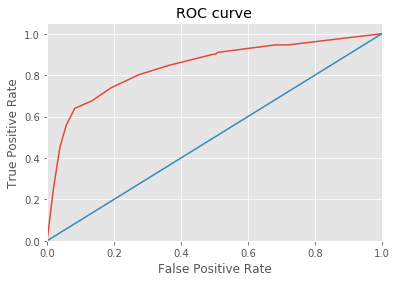

In [343]:
print('Accuracy =', accuracy_score(y_test, y_predicted))
print('Precision =', precision_score(y_test, y_predicted))
print('Recall =', recall_score(y_test, y_predicted))
print('F1_score =', f1_score(y_test, y_predicted))
print('AUC =', roc_auc_score(y_test, y_proba[:,1]))

fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1])
# Рисуем картиночку
plt.plot(fpr, tpr, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

По аналогии можно посмотреть на важность фичей.

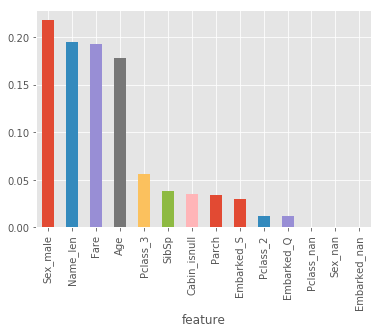

In [344]:
featureImportance = pd.DataFrame({"feature": df.drop('Survived',axis=1).columns, 
                                  "importance": rfc.feature_importances_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar')

# 5. Подбор гиперпараметров

Выше мы уже попробовали подбирать параметры для метода ближайших соседей. Мы делали это по тестовой выборке. Это превращало её в обучающую выборку. Это плохо. 

На практике обычно делают перебор параметров с помощью кросс-валидации. Мы уже решили одну игрушечную задачку на это на доске. Давайте научимся делать это в питоне. 

In [346]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_neighbors':range(5, 100), 'weights':['uniform', 'distance']}

knc = KNeighborsClassifier()

clf = GridSearchCV(knc, parameters)

clf.fit(X_train, y_train)
clf.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=14, p=2,
           weights='uniform')

In [347]:
y_proba = clf.predict_proba(X_test)[:,1]
print('AUC =', roc_auc_score(y_test, y_proba))

AUC = 0.7437596832501291


Сделаем то же самое для случайного леса!

In [356]:
parameters = {
              'n_estimators': [10,20,50,70,100],           # число деревьев в лесу
              'min_samples_leaf': [1, 3, 5, 7, 10],        # минимальное число объектов в каждом листе
             }
# Можно перебирать и другие параметры 

rfc = RandomForestClassifier(random_state=42)   # random_state = 42 фиксируем для воспроизводимости результата

gcv = GridSearchCV(rfc, parameters, n_jobs= -1) # параметр n_jobs=-1 распаралеливает перебор на все ядра компухтера
gcv.fit(X, y)
gcv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [357]:
y_predicted = gcv.predict(X_test)
y_proba = gcv.predict_proba(X_test)

In [358]:
y_proba = clf.predict_proba(X_test)[:,1]
print('AUC =', roc_auc_score(y_test, y_proba))

AUC = 0.7437596832501291


# 6. Прогнозы

Пришло время узнать выжили бы вы на титанике по мнению наших свежеобученых алгоритмов.

![](https://medialeaks.ru/wp-content/uploads/2016/02/15.jpg)

In [ ]:
Survived - выжил человек или нет, целевая переменная
Pclass - класс, в котором ехал человек
Name - имя человека
Sex - пол
Age - возраст
SibSp - сколько было на борту братьев, сестер, супругов на борту Титаника
Parch - число детей и родителей на борту Титаника
Ticket - номер билета
Fare - стоимость билета
Cabin - номер каюты
Embarked - порт посадки (C = Шербур, Q = Квинстаун, S = Саутгемптон)


In [448]:
you_dict = {'Age'  : [23],    # ваш возраст
            'SibSp': [0],     # сколько на борту ваших братьев, сестер, супругов
            'Parch': [0],     # сколько на борту было ваших родителей и детей
            'Fare': [100],     # стоимость вашего билета в долларах 
            'Pclass_2': [0],  # в каком классе вы ехали (если в первом, поставьте в Pclass2 и Pclass3 нули)
            'Pclass_3': [0],
            'Pclass_nan':[0], # эту переменную не трогать!
            'Sex_male' : [1], # если вы мужчина, поставьте 1, если женщина, 0
            'Sex_nan' : [0],  # эту переменную не трогать!  
            'Embarked_Q': [0],# из какого вы порта, если из C, то поставьте в Q и S нули
            'Embarked_S': [0],
            'Embarked_nan': [0], # эту переменную не трогать!
            'Name_len': [20],    # суммарная длина ваших имени и фамилии и титула, если есть
            'Cabin_isnull': [0] # была ли у вас каюта, 0 если да
           }

In [449]:
df_new = pd.DataFrame.from_dict(you_dict)

X_new = df_new[['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_2', 'Pclass_3', 'Pclass_nan', 
        'Sex_male', 'Sex_nan', 'Embarked_Q', 'Embarked_S', 'Embarked_nan', 'Name_len', 'Cabin_isnull']].values

In [450]:
print('По мнению алгоритма ближайших соседей вы выживите с вероятностью {}'.format(
                        round(clf.predict_proba(X_new)[:,1][0],2)))

print('По мнению случайного леса вы выживите с вероятностью {}'.format(
                        round(gcv.predict_proba(X_new)[:,1][0],2)))

По мнению алгоритма ближайших соседей вы выживите с вероятностью 0.86
По мнению случайного леса вы выживите с вероятностью 0.47
